In [3]:
!pip install wbgapi

You should consider upgrading via the '/Users/mac/.pyenv/versions/3.10.3/bin/python3.10 -m pip install --upgrade pip' command.


In [711]:
import wbgapi as wb
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import matplotlib
from datetime import datetime
from dataclasses import dataclass

In [2641]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### Query the environmental score, methane emission (kt of CO2 equivalent)
- #### Methane emissions from energy processes are emissions from the production, handling, transmission, and combustion of fossil fuels and biofuels.
- #### At standard temperature and pressure, one metric ton of carbon dioxide (CO₂) would fill a sphere 32 feet (about 9.8 meters) in diameter. The average car in the U.S. will produce this over a three-month period.

In [2642]:
wb.series.info(q='electricity')

ConnectionError: HTTPSConnectionPool(host='api.worldbank.org', port=443): Max retries exceeded with url: /v2/en/sources/2/series/all?per_page=1000&page=1&format=json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f86348ef4f0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [ ]:
wb.series.info(q='Renewable')

- NY.GDP.PCAP.CD	GDP per capita (current US)
- IS.AIR.DPRT	Air transport, registered carrier departures worldwide
- EG.USE.ELEC.KH.PC	Electric power consumption (kWh per capita)
- AG.LND.TOTL.K2	 Land area (sq. km)
- EN.ATM.METH.AG.KT.CE and EN.ATM.METH.AG.ZS : Agricultural methane emissions are emissions from animals, animal waste, rice production, agricultural waste burning (nonenergy, on-site), and savanna burning.
- EN.ATM.METH.EG.KT.CE and EN.ATM.METH.EG.ZS : Methane emissions from energy processes are emissions from the production, handling, transmission, and combustion of fossil fuels and biofuels.
- EN.ATM.METH.KT.CE and EN.ATM.METH.ZG: Methane emissions are those stemming from human activities such as agriculture and from industrial methane production.
- EG.ELC.NGAS.ZS	Electricity production from natural gas sources (% of total)
- EG.FEC.RNEW.ZS	Renewable energy consumption (% of total final energy consumption)
- EG.USE.COMM.FO.ZS	Fossil fuel energy consumption (% of total)


In [2915]:
QUERY_ID = ['EN.ATM.METH.EG.KT.CE']

features = ['EN.ATM.METH.EG.ZS','EN.ATM.METH.ZG', 
            'EN.ATM.METH.AG.ZS', 'EN.ATM.METH.AG.KT.CE',
           'NY.GDP.PCAP.CD', 'IS.AIR.DPRT', 'EG.USE.ELEC.KH.PC', 'AG.LND.TOTL.K2', 
            'EN.ATM.METH.AG.KT.CE', 'EN.ATM.METH.AG.ZS','EN.ATM.METH.EG.KT.CE', 'EN.ATM.METH.EG.ZS', 
            'EN.ATM.METH.KT.CE', 'EN.ATM.METH.ZG', 'EG.ELC.NGAS.ZS', 'EG.FEC.RNEW.ZS', 'EG.USE.COMM.FO.ZS',
            'EN.ATM.CO2E.KT', 'EG.USE.PCAP.KG.OE', 'EG.USE.CRNW.ZS'
           ]

BEGIN_YEAR_AVAILABLE = 1990
LAST_YEAR_AVAILABLE = 2019

#### GET OUR DATA FROM WORLD BANK API

We retrieve the data from the API using CountryAlpha2Code and the period time
- CountryAlpha2Code : later.....
- period time : later....

In [2916]:
def HandlingPeriodFormatInput(year) :
    if year < BEGIN_YEAR_AVAILABLE :
        raise Exception ("The data available starting in 1990")
    if year > CURRENT_YEAR_AVAILABLE : #prediction
        period_time = range(BEGIN_YEAR_AVAILABLE, year)
        return period_time
    else :
        period_time = range(BEGIN_YEAR_AVAILABLE, CURRENT_YEAR_AVAILABLE)
        return period_time
        
    
        
        

In [2917]:
def HandlingPeriodFormatInput(period_time) :
    
    if type(period_time) == int:      
        period_time = range(BEGIN_YEAR_AVAILABLE, period_time +1)
        return period_time
    
    if period_time[0] < BEGIN_YEAR_AVAILABLE :
        raise Exception ("The data available starting in 1990")
        
    if len(period_time) > 3 :
        raise Exception ("The format given is not correct try this format [initial date, final date, step")
        
    if len(period_time) == 2 :
        period_time.insert(2, 1)
        warnings.warn("the format should be [initial date, final date, step")

    if max(period_time) > CURRENT_YEAR_AVAILABLE + 1 or min(period_time) > CURRENT_YEAR_AVAILABLE:

        new_period_time = range(min(2021, period_time[0]), min(2022, period_time[1]), period_time[2])
    else :
         new_period_time = range(period_time[0], period_time[1], period_time[2])

    return new_period_time


In [2918]:
HandlingPeriodFormatInput(1990)

range(1990, 1991)

In [2919]:
@dataclass
class Country : 
    name : str
    CountryAlpha2Code : str
    period_time : list
    query_id : list

    def queryMethaneData(self) -> pd.DataFrame : #getDataMethEmissionByCountryAndYears
        period_time_range = HandlingPeriodFormatInput(self.period_time)
        df = wb.data.DataFrame(self.query_id, self.CountryAlpha2Code, time = period_time_range, columns='series')   
        return df.reset_index()
    
    def queryRelatedIndicators(self, predictors) -> pd.DataFrame :
        period_time_range = HandlingPeriodFormatInput(self.period_time)
        df = wb.data.DataFrame(predictors, self.CountryAlpha2Code, time = period_time_range, columns='series')   
        return df.reset_index()
        
        
        
    
    def plot(self):
        try :
            self.queryMethaneData().set_index('time').plot(figsize=(15, 6), title= self.name, colormap='jet')
        except :
            self.queryMethaneData().plot(figsize=(15, 6), title= self.name, colormap='jet')
        

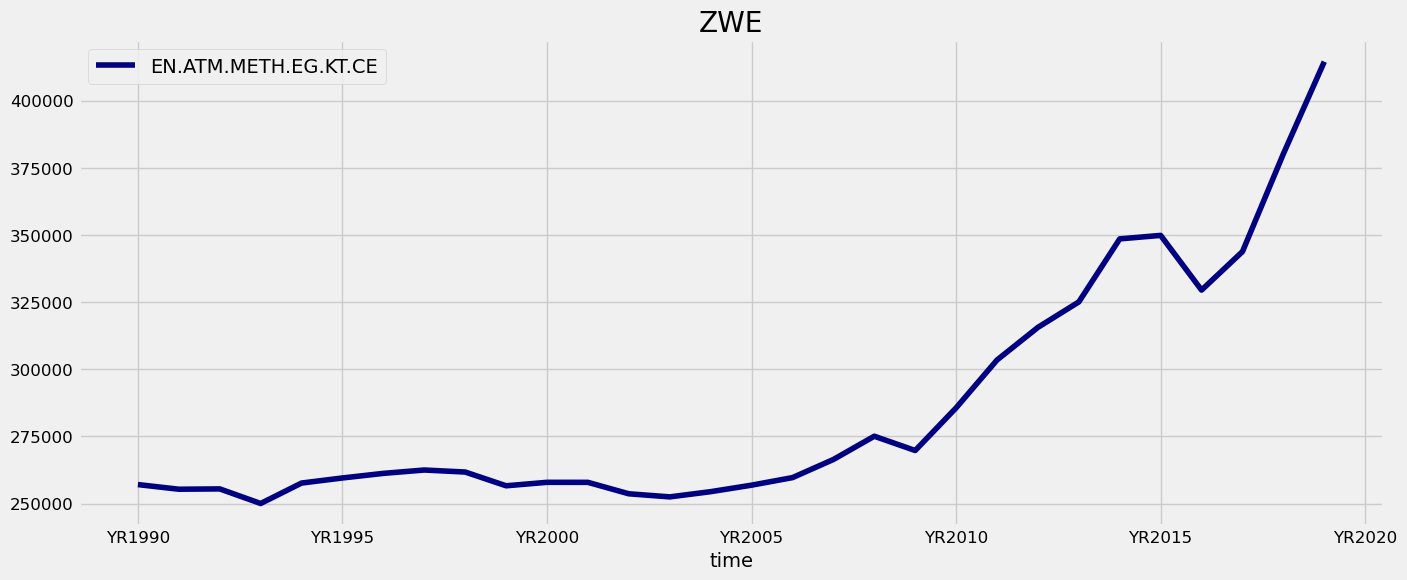

In [2921]:
country = Country('ZWE', 'USA', [1990, 2026, 1], QUERY_ID)
data_country = country.queryMethaneData()
country.plot()

In [2922]:
data_country[QUERY_ID[0]].values

array([257090., 255360., 255480., 250050., 257660., 259550., 261260.,
       262510., 261760., 256640., 257930., 257920., 253660., 252510.,
       254450., 256870., 259680., 266430., 275090., 269770., 285650.,
       303460., 315600., 325080., 348540., 349840., 329480., 343810.,
       380210., 414500.,     nan,     nan])

#### DATA PREPROCESSING

In [3035]:
@dataclass
class DataMethCountryPreprocessing :
    
    country : Country
    df: pd.DataFrame


    def CleaningAndRename(self):
        self.df['date'] = self.df['time'].str[2:]
        self.df['date'] = pd.to_datetime(self.df['date'])
        self.df = self.df.rename(columns = {'EN.ATM.METH.EG.KT.CE' : 'ktofCO2'})
        del self.df['time']
        self.df = self.df.set_index('date')


    def HandlingFormatDateIndex(self) :
        BeginYear, LastYearToPredict,_ = self.country.period_time
        start = str(BeginYear) + "-01-01"
        end = str(LastYearToPredict) + "-01-01"
        dates = pd.date_range(start=start,end=end)
        self.df= self.df.reindex(dates, fill_value=0)
        self.df = self.df.resample('Y').sum().reset_index()
        self.df['index'] = self.df['index'].dt.year
        self.df= self.df.rename(columns={'index':'year'})
        self.df = self.df.set_index('year')
        self.df.replace(0.0, pd.np.nan, inplace=True)
        
    def MissingValue(self) :
        return sns.heatmap(self.df.isnull(),yticklabels=True,cbar=True,cmap='viridis')



<AxesSubplot: ylabel='year'>

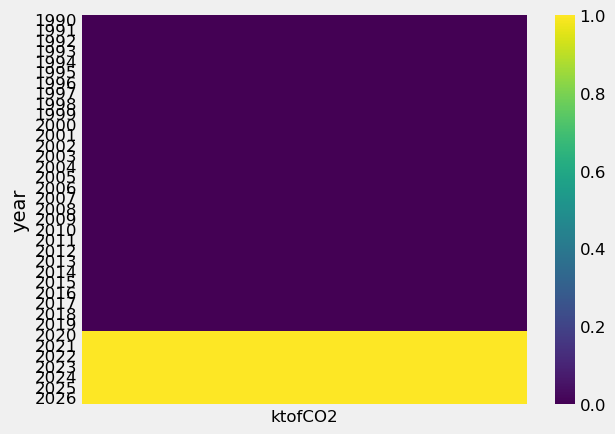

In [2925]:
DMCP = DataMethCountryPreprocessing(country, data_country)
DMCP.CleaningAndRename()
DMCP.HandlingFormatDateIndex()
DMCP.MissingValue()

In [2926]:
df = DMCP.df
# df.replace(0.0, pd.np.nan, inplace=True)
df

,ktofCO2
year,
1990,257090.0
1991,255360.0
1992,255480.0
1993,250050.0
1994,257660.0
1995,259550.0
1996,261260.0
1997,262510.0
1998,261760.0


### Handling Missing data

<AxesSubplot: >

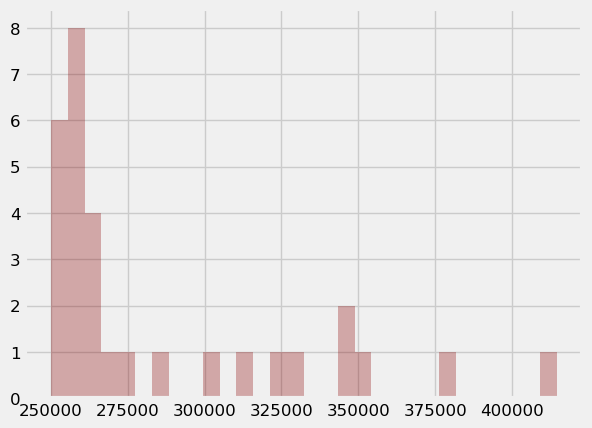

In [2927]:
df['ktofCO2'].hist(bins=30,color='darkred',alpha=0.3)

<AxesSubplot: xlabel='ktofCO2'>

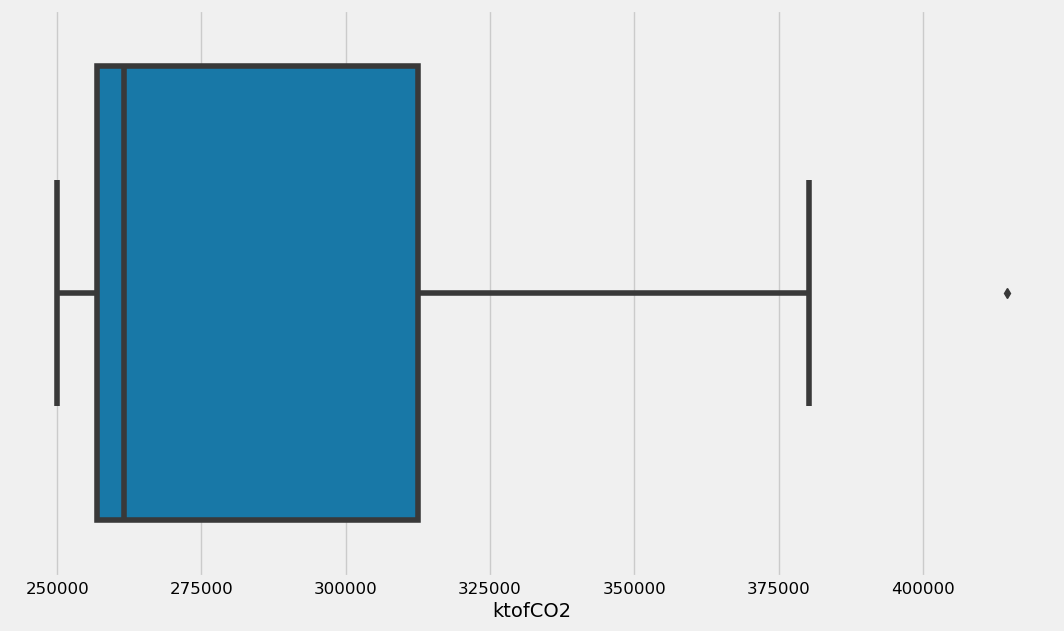

In [2928]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='ktofCO2',data=df,palette='winter')

#### 1ere METHOD USING Rolling Statistical

In [2929]:
def rolling_statistical(df, window_size, kind):
    
    weights = np.linspace(1, window_size, window_size)*0.1
    print(weights)
    df_imputed = df.copy()
    
    for column in df.columns:
        if kind == 'SMA':
            function = df_imputed[column] \
                                .rolling(window_size, min_periods=1) \
                                .mean().interpolate() 
            
            df_imputed[column].fillna(function, inplace=True)
            
        elif kind == 'WMA' :
            function = df_imputed[column].rolling(window_size).apply(
                lambda x: np.sum(weights*x)).interpolate()
            
            df_imputed[column].fillna(function, inplace=True)
            

        elif kind == 'EMA' :
            df_imputed[column] = df_imputed[column].fillna(df_imputed[column].ewm(span=window_size).mean())
            
    df_imputed[column].plot(figsize=(15, 6), title= 'Rolling_statistical', colormap='jet')
    plt.show()
            
    return df_imputed

[0.1 0.2 0.3 0.4]


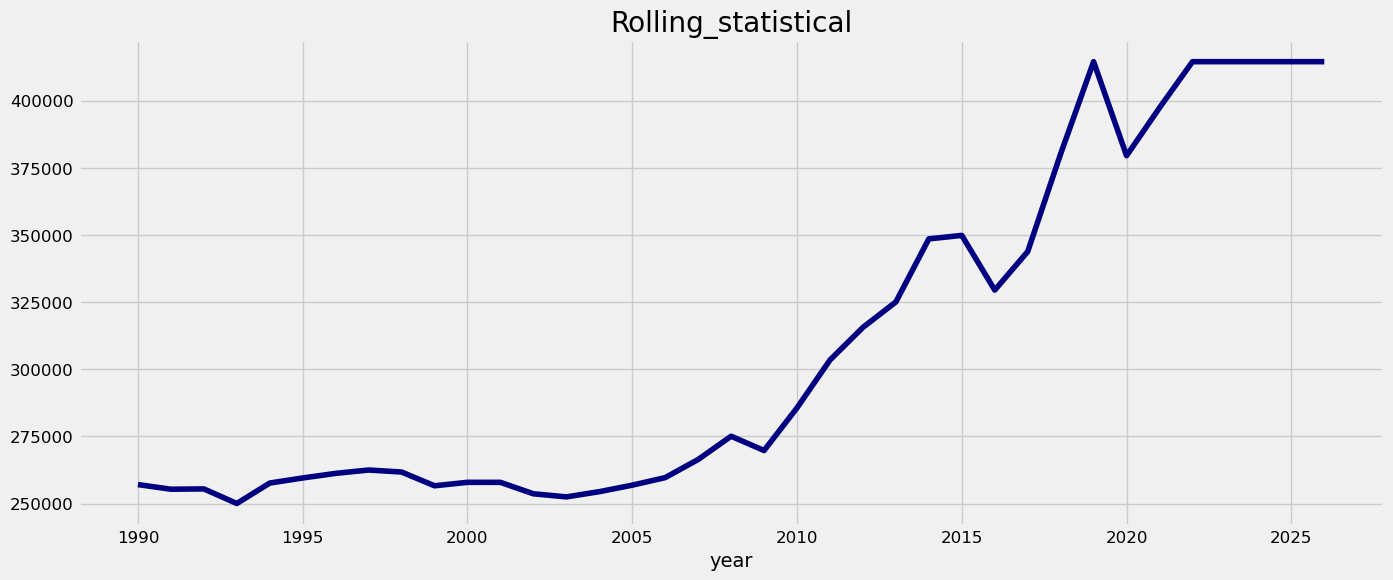

In [2930]:
df_imputed = rolling_statistical(df, 4, 'SMA')

In [2931]:
def imputwithKNNImputer(df,k):
    imputer = KNNImputer(n_neighbors= k)
    imputed_data = imputer.fit_transform(df)
    df_imputed = pd.DataFrame(imputed_data, 
                           columns = df.columns)
    df_imputed.index = df.index
    for column in df.columns :
        df_imputed[column].plot(figsize=(15, 6), title= 'KNNImputer', colormap='jet')
        plt.show()
      
    return df_imputed

In [2932]:
def Imputewithlinear_interpolation(df, order, kind='linear'):
    for column in df.columns :
        df[column ] = df[column].interpolate(method=kind, order=order)
        df[column].plot(figsize=(15, 6), title= 'linear_interpolation', colormap='jet')
        plt.show()
    return df

In [2933]:
import pandas as pd
import numpy as np
import random

def replace_random_values(df, fraction):
    for column in df.columns:
        df_train = df.copy()
        print(np.random.rand(len(df_train)))
        mask = np.random.rand(len(df_train)) < fraction
        if mask[0] == True:
            mask[0] = False
        df_train[column][mask] = np.nan
    return df_train

In [2934]:
def compute_uncertainty(df, model, nbr_sim, kind_rolling= 'SMA', kind_interpo= 'linear', order = 1, windows_size = 4, k=3):
    df = df.dropna()
    for column in df.columns :
        all_estimations_error = []
        for _ in range(1, nbr_sim + 1) :
            df_random_null_value = replace_random_values(df, 0.5)
            if model == 'rolling_statistical' :
                df_predict = rolling_statistical(df_random_null_value, windows_size, kind)
            elif model == 'KNNImputer' :
                df_predict = imputwithKNNImputer(df_random_null_value , k)
                
        
            elif model == 'Linear_interpolation':
                    df_predict = Imputewithlinear_interpolation(df_random_null_value, order, kind= kind_interpo)
                    
                
            mse = np.sqrt(mean_squared_error(df[column], df_predict[column]))
            all_estimations_error.append(mse)

        # compute the mean, standard deviation and confidence interval of the results
        mean = np.mean(all_estimations_error)
        std = np.std(all_estimations_error)
        confidence_interval = (mean - 1.96*std, mean + 1.96*std)
        print('Mean: ', mean)
        print('Standard deviation: ', std)
        print('Confidence interval: ', confidence_interval)
        
        return std

    

[0.30752042 0.19253881 0.53868288 0.23797117 0.00114279 0.53954031
 0.38457679 0.64225531 0.64768329 0.39454418 0.22786445 0.49107583
 0.88353281 0.23812147 0.08754381 0.49454542 0.77054738 0.89553307
 0.98264089 0.4463764  0.46573502 0.13249775 0.94487678 0.10287197
 0.86568459 0.88529884 0.56678695 0.88803894 0.80560695 0.40689297]


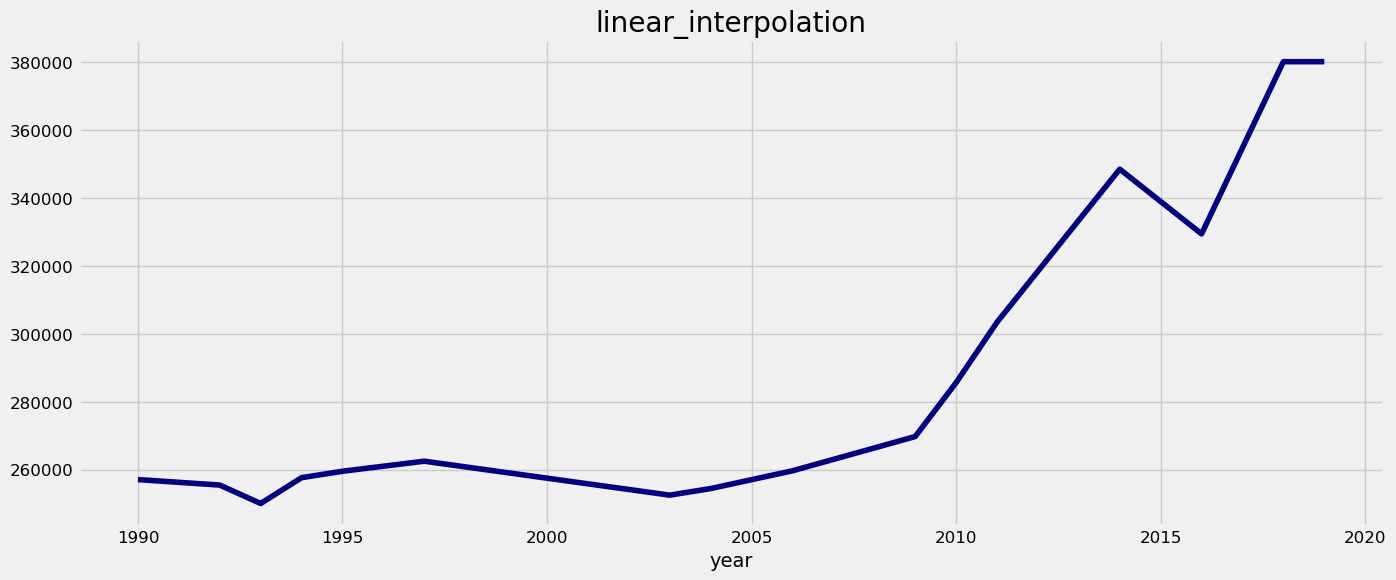

[0.47064264 0.42363363 0.12504559 0.4562715  0.12270902 0.22819116
 0.84243703 0.22192577 0.58660877 0.32290084 0.64988649 0.92265237
 0.81991311 0.13617519 0.04926997 0.82411976 0.64092881 0.49680179
 0.64224273 0.84308205 0.4799728  0.62941646 0.6101102  0.12999885
 0.70122212 0.31596116 0.92561249 0.09272395 0.09205129 0.02583216]


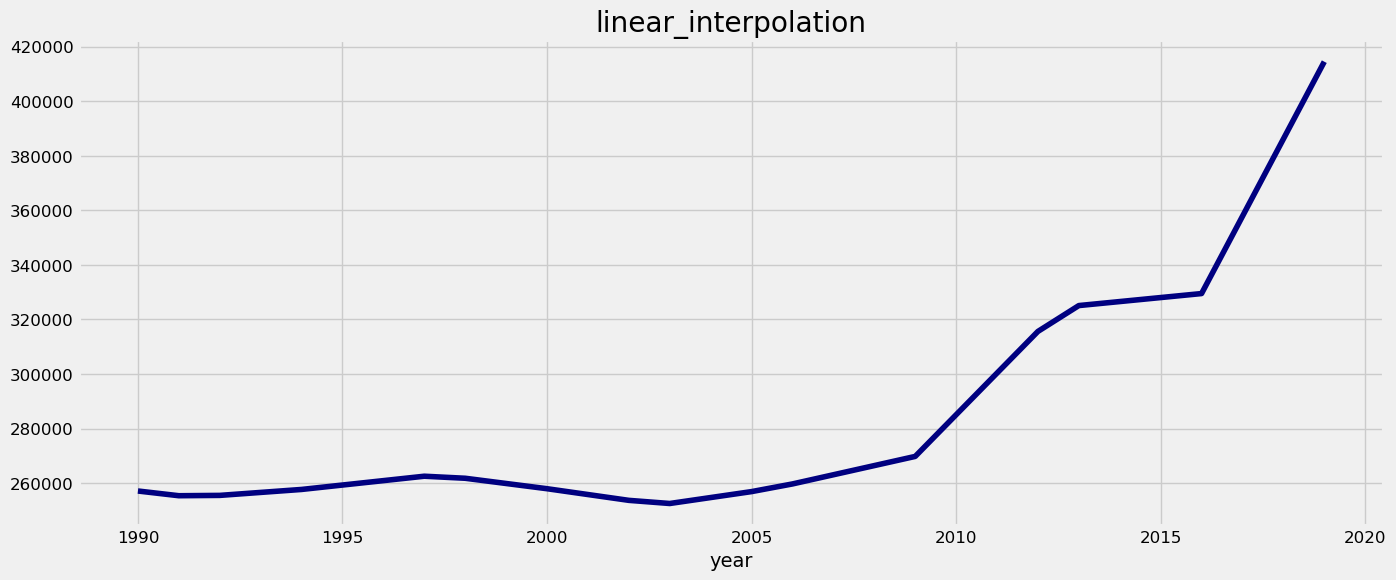

[0.97393463 0.54642488 0.06442332 0.90593173 0.53977032 0.86987421
 0.64836355 0.04804158 0.03636723 0.10386223 0.38516125 0.86102638
 0.60933768 0.46241142 0.00600677 0.16033844 0.63363191 0.86216527
 0.16139859 0.30264613 0.99814435 0.25311928 0.52075336 0.11051289
 0.56597906 0.03500597 0.55169568 0.41728703 0.04338154 0.03163575]


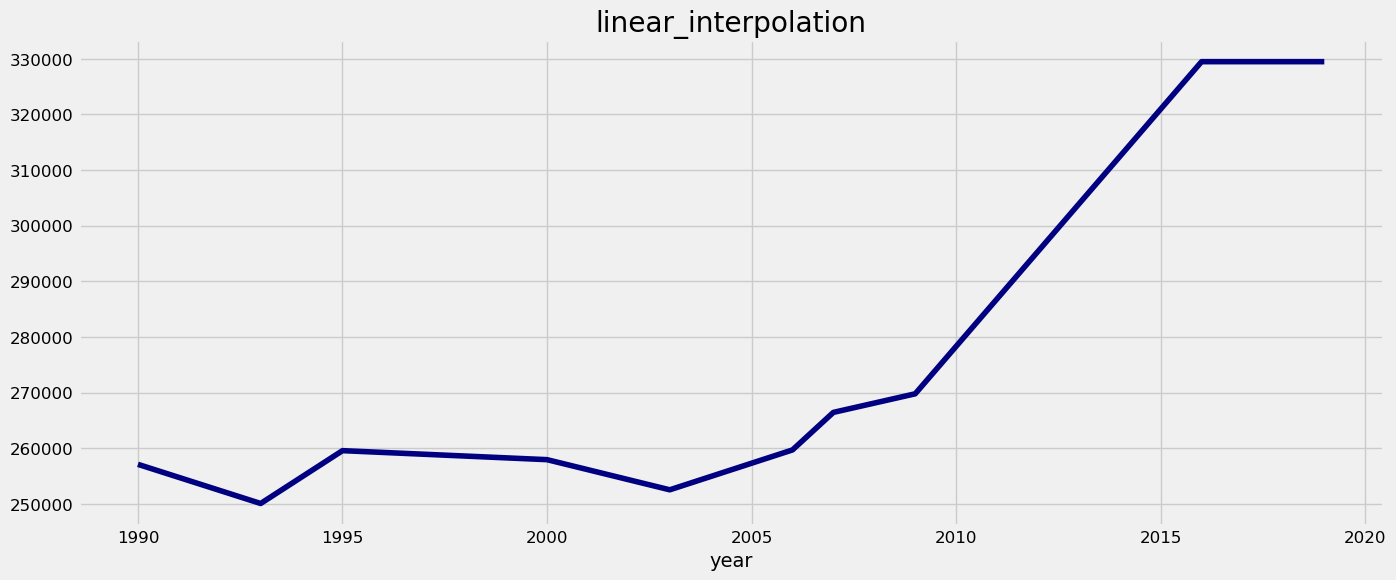

[0.6622426  0.46592984 0.51837638 0.72949134 0.90266448 0.69147171
 0.76125284 0.59095552 0.61581588 0.31061781 0.82670115 0.67700451
 0.03115378 0.85414222 0.73157349 0.57317533 0.91322332 0.90386605
 0.03713888 0.76840381 0.39168226 0.53695699 0.34288092 0.33864989
 0.56911383 0.53548325 0.76682163 0.85087331 0.79216097 0.86731474]


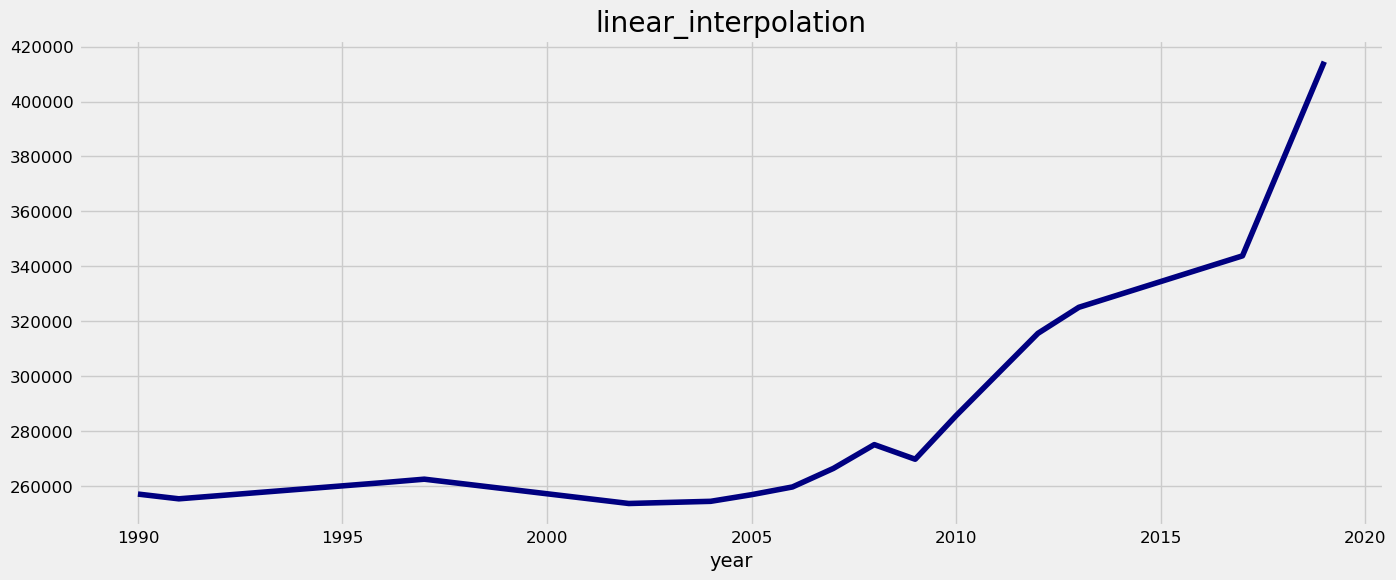

[0.08932026 0.80579773 0.99946679 0.6983927  0.19076884 0.41014002
 0.8746162  0.80333496 0.07467653 0.88715474 0.86840692 0.47367832
 0.35806934 0.63734197 0.59373    0.05955612 0.68158095 0.68869889
 0.78301126 0.0315154  0.73627909 0.28966232 0.53044689 0.85193413
 0.09521676 0.55457304 0.67230492 0.36919073 0.120752   0.78872286]


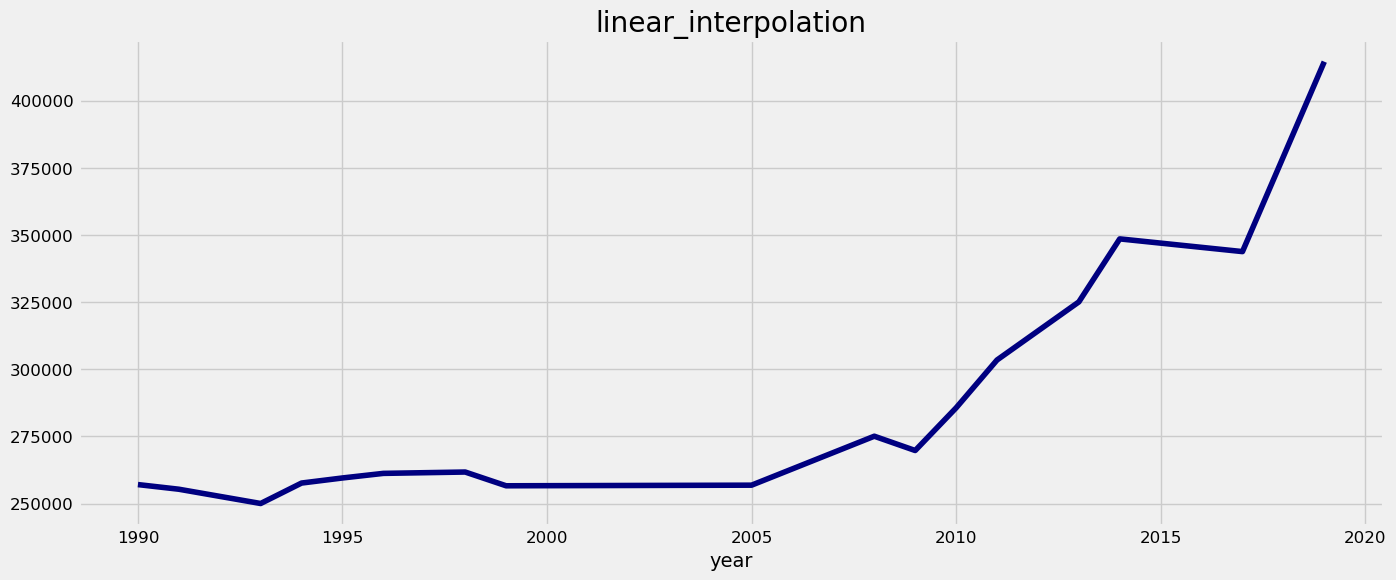

[0.55322959 0.08014451 0.4314438  0.65321126 0.73214367 0.50625124
 0.37251865 0.09662289 0.17683176 0.83570354 0.4527435  0.15714371
 0.55790198 0.22481414 0.36957844 0.56671352 0.96881584 0.36832151
 0.47850493 0.35689028 0.86949491 0.47766756 0.14107312 0.76172314
 0.63814766 0.62320532 0.86902339 0.64130023 0.66826983 0.88725559]


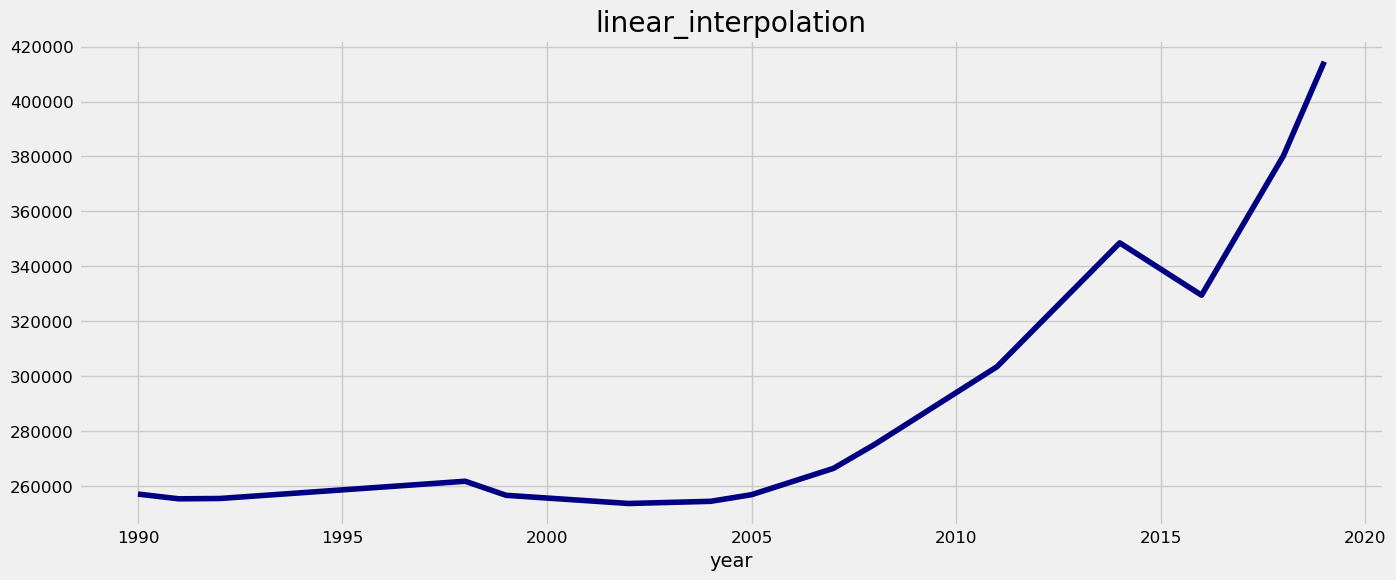

[0.03263242 0.89430057 0.92580787 0.04006217 0.05962128 0.15463843
 0.00460628 0.80177887 0.38443548 0.42186494 0.42641754 0.54008884
 0.15231829 0.95117259 0.18737319 0.37304833 0.4289383  0.65079117
 0.15065974 0.36391724 0.8655153  0.10814861 0.01928636 0.5402381
 0.94691877 0.30153331 0.33914819 0.00611052 0.29438507 0.88979091]


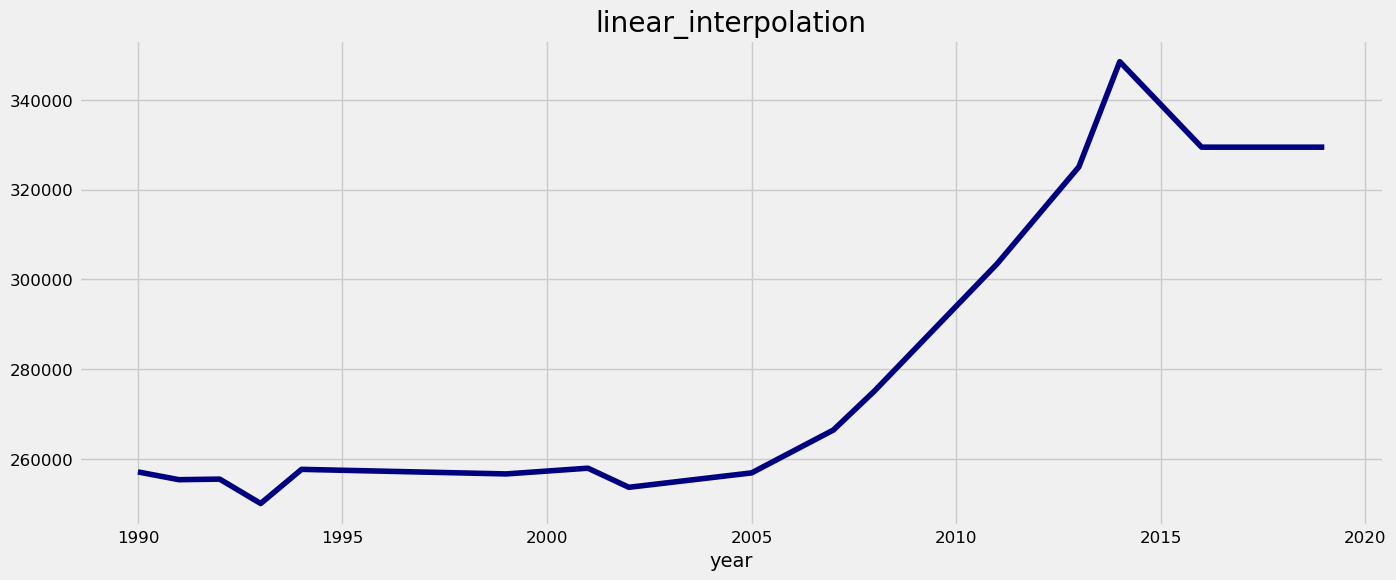

[0.96410458 0.79306173 0.72711662 0.01469779 0.74281313 0.96700163
 0.44720497 0.93830449 0.41954253 0.97418151 0.07792323 0.2388695
 0.32998803 0.01347901 0.03215555 0.21656482 0.10634489 0.76056064
 0.65887482 0.93863443 0.77227662 0.24167825 0.91571928 0.48944804
 0.32810861 0.26380141 0.82852679 0.19602823 0.74295578 0.98764047]


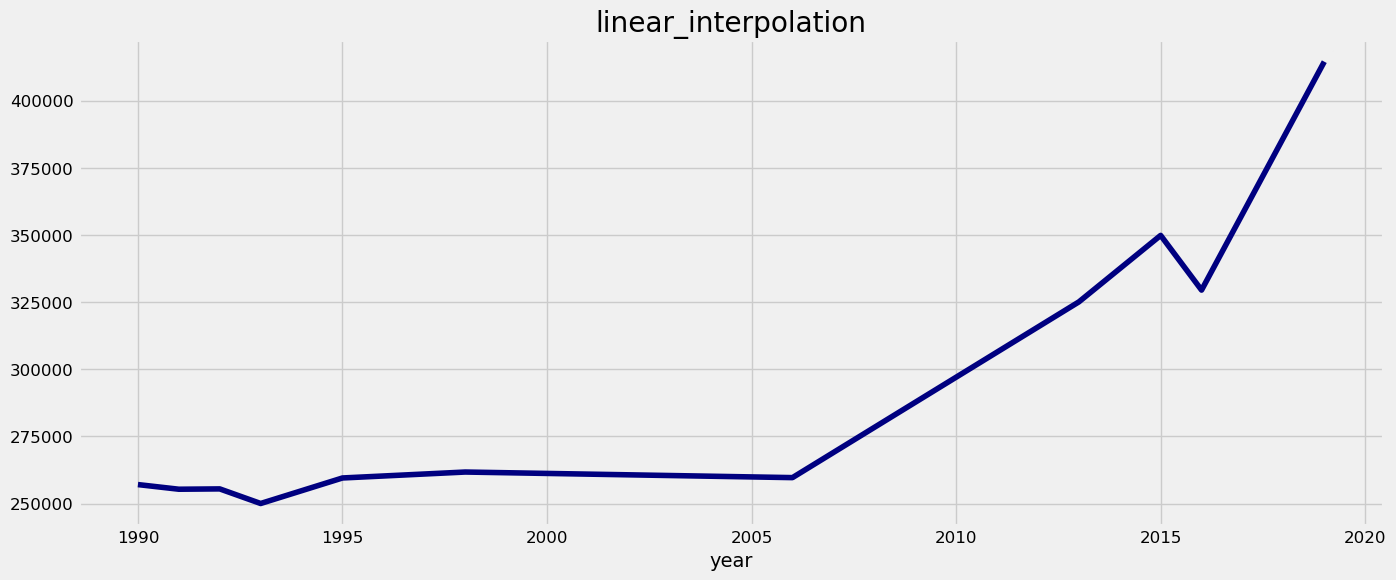

[0.11247904 0.78882381 0.55672755 0.23858638 0.63130838 0.82080746
 0.73228375 0.6647097  0.98228412 0.86846105 0.98475694 0.34643115
 0.16416341 0.56702917 0.08216361 0.05622003 0.86314242 0.62000508
 0.50466036 0.25124831 0.81402674 0.28996073 0.30690505 0.30639498
 0.92659772 0.35432645 0.05680063 0.37404096 0.31989662 0.28092338]


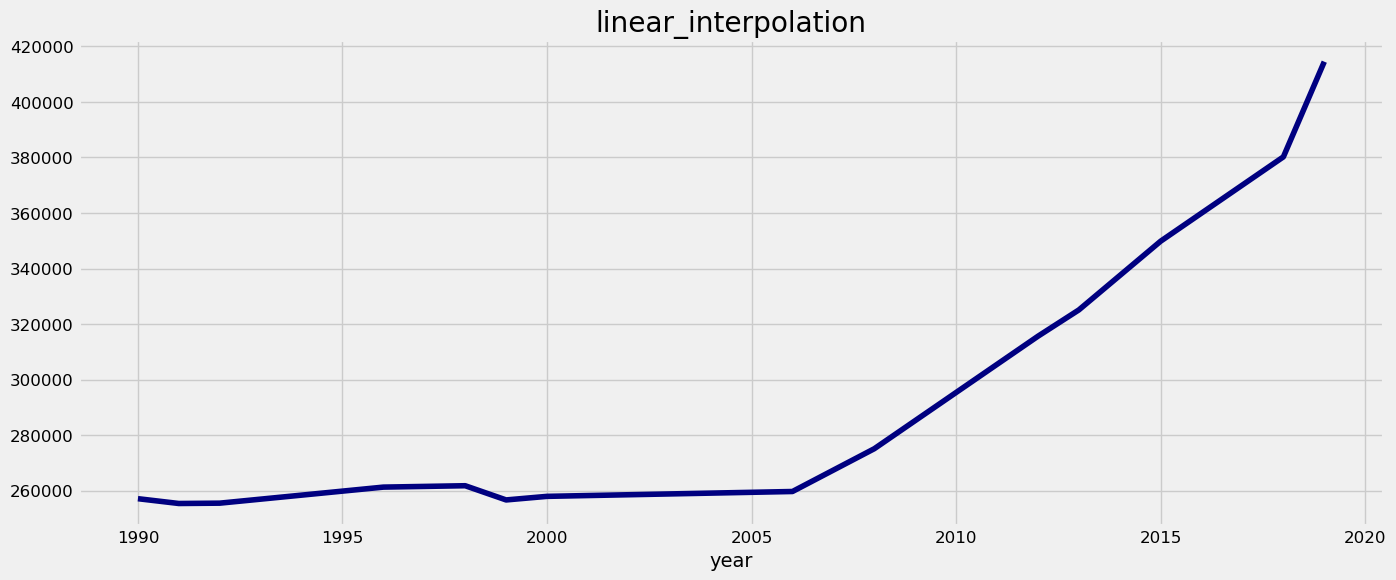

[0.32965784 0.21861862 0.09475077 0.98242916 0.63250552 0.79482814
 0.49169352 0.23199752 0.67711595 0.58299416 0.20266927 0.6508242
 0.3351837  0.06030232 0.49267102 0.39835453 0.41527554 0.93399293
 0.41774246 0.98498506 0.15895667 0.16865412 0.46290437 0.66115336
 0.18095989 0.25674911 0.26610754 0.65788845 0.65622202 0.04499446]


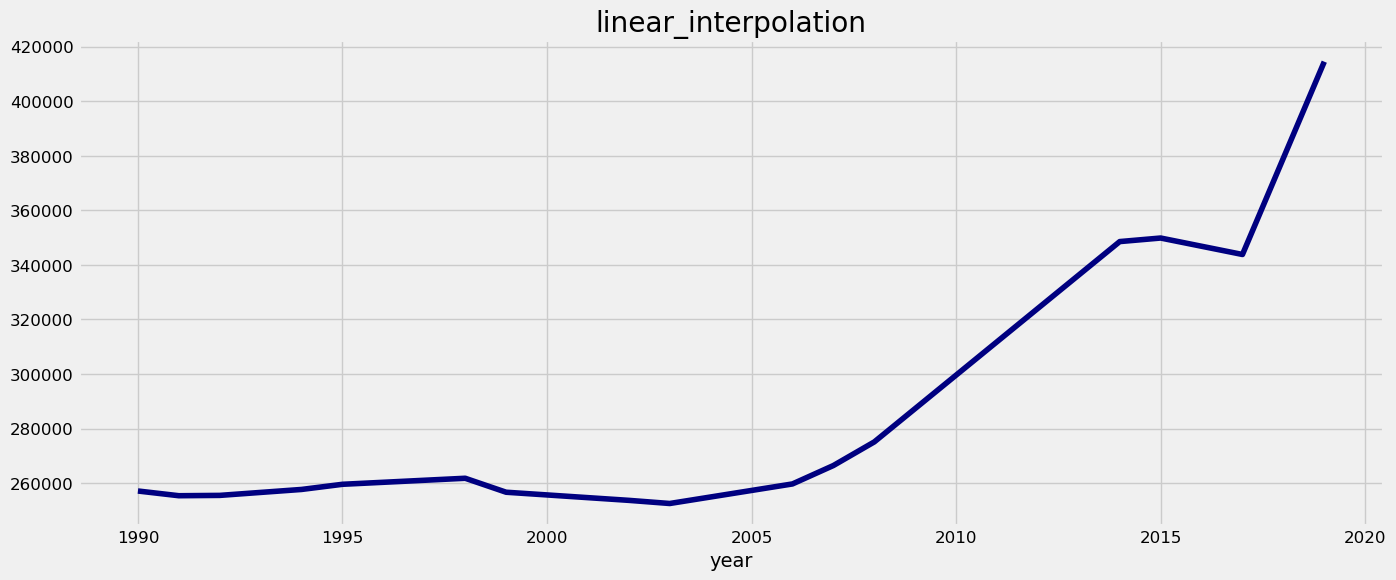

Mean:  8762.216936276975
Standard deviation:  5777.617103136631
Confidence interval:  (-2561.912585870823, 20086.34645842477)


5777.617103136631

In [2935]:
compute_uncertainty(df, 'Linear_interpolation', 10)

### Obtain and estimate when possible the Methane emissions for the last 10 years in all countries

In [2936]:
df_methane_emission_ten_y = wb.data.DataFrame(['EN.ATM.METH.KT.CE'], mrv=10, columns = 'series').reset_index()

In [2937]:
df_methane_emission_ten_y.to_csv('world_methane_emission_10y.csv')

### Give an estimate of the Methane emissions for all countries for the next 5 years

In [2943]:
DICO_GLOBAL_METHANE = {'EN.ATM.METH.ZG':'GlobalMethane(pct_change)', 
                       'EN.ATM.METH.KT.CE':'GlobalMethane(ktco2)'}

In [2944]:
DICO_ENERGY = {'EN.ATM.METH.EG.ZS':'EnergieMethane', 
               'EN.ATM.METH.EG.KT.CE':'EnergieMethane(ktco2)', 
              }
DICO_ENERGY_RELATED = {'IS.AIR.DPRT':'AirTransport', 'EG.USE.ELEC.KH.PC': 'ConsoElec', 
                       'EG.ELC.NGAS.ZS':'EnergieNatualGaz(%total)',
              'EG.FEC.RNEW.ZS':'RenewableConso(%totalconso)', 
                       'EG.USE.COMM.FO.ZS':'FossilfuelConso(%totalconso)',
              'EN.ATM.CO2E.KT': 'CO2Emission(kt)', 
                'EG.USE.PCAP.KG.OE':'PrimaryEnergy(kgoil)', 
                       'EG.USE.CRNW.ZS':'PrimaryEnergy(%total)'}

In [2945]:
DICO_AGRICULTURE_METHANE = {'EN.ATM.METH.AG.KT.CE':'AgricultureMethane(ktco2)', 
                    'EN.ATM.METH.AG.ZS':'AgricultureMethane(٪total)'
                   }

DICO_AGRICULTURE_RELATED = {'AG.LND.TOTL.K2':'LandArea(count)' }


In [2946]:
features = ['EN.ATM.METH.EG.ZS','EN.ATM.METH.ZG', 
            'EN.ATM.METH.AG.ZS', 'EN.ATM.METH.AG.KT.CE', 'IS.AIR.DPRT', 
            'EG.USE.ELEC.KH.PC', 'AG.LND.TOTL.K2', 'EN.ATM.METH.AG.KT.CE',
            'EN.ATM.METH.AG.ZS','EN.ATM.METH.EG.KT.CE','EN.ATM.METH.EG.ZS', 
            'EN.ATM.METH.KT.CE', 'EN.ATM.METH.ZG', 'EG.ELC.NGAS.ZS', 'EG.FEC.RNEW.ZS', 
            'EG.USE.COMM.FO.ZS','EN.ATM.CO2E.KT', 'EG.USE.PCAP.KG.OE', 'EG.USE.CRNW.ZS'
           ]

In [2942]:
world_methane_emission = wb.data.DataFrame(features, columns = 'series').reset_index()

In [1617]:
world_methane_emission.to_csv('world_methane_emission_new.csv')

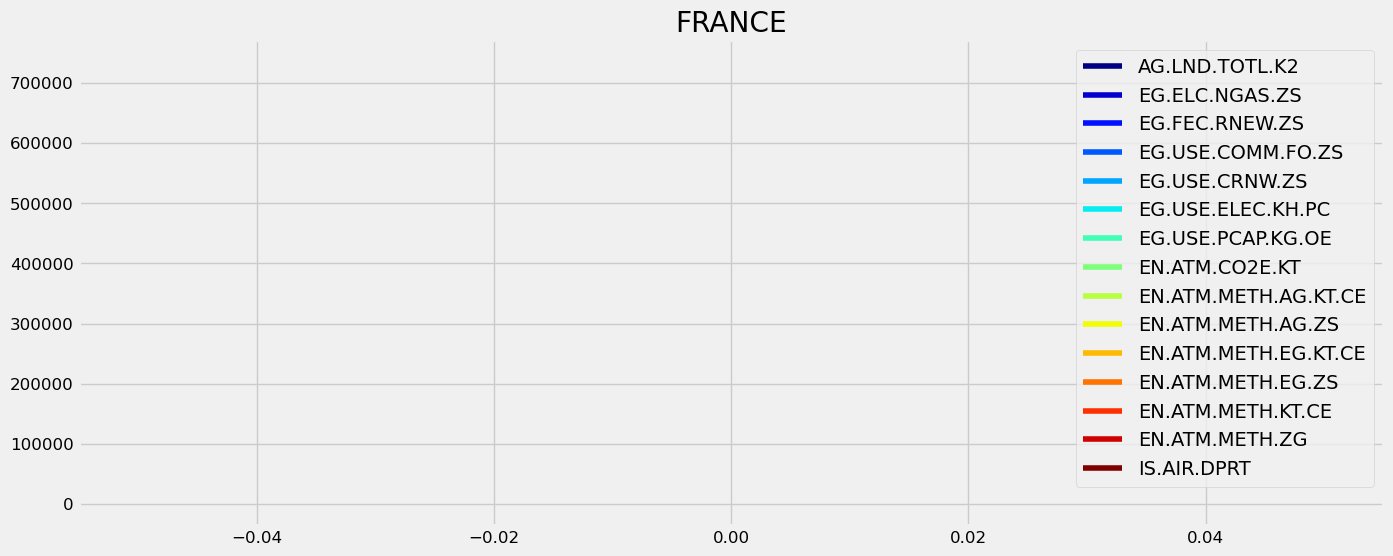

In [1689]:
country = Country('FRANCE', 'FRA', 2002, features)
data_country = country.queryMethaneData()
country.plot()

In [1690]:
data_country

,economy,AG.LND.TOTL.K2,EG.ELC.NGAS.ZS,EG.FEC.RNEW.ZS,EG.USE.COMM.FO.ZS,EG.USE.CRNW.ZS,EG.USE.ELEC.KH.PC,EG.USE.PCAP.KG.OE,EN.ATM.CO2E.KT,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.AG.ZS,EN.ATM.METH.EG.KT.CE,EN.ATM.METH.EG.ZS,EN.ATM.METH.KT.CE,EN.ATM.METH.ZG,IS.AIR.DPRT
0,FRA,547567.0,3.31792,8.73,52.813534,3.169762,7297.953479,4224.718316,371019.989014,46780.0,64.06464,5430.0,8.709942,72089.996338,10.805748,734679.0


In [1618]:
world_methane_emission

,economy,time,AG.LND.TOTL.K2,EG.ELC.NGAS.ZS,EG.FEC.RNEW.ZS,EG.USE.COMM.FO.ZS,EG.USE.CRNW.ZS,EG.USE.ELEC.KH.PC,EG.USE.PCAP.KG.OE,EN.ATM.CO2E.KT,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.AG.ZS,EN.ATM.METH.EG.KT.CE,EN.ATM.METH.EG.ZS,EN.ATM.METH.KT.CE,EN.ATM.METH.ZG,IS.AIR.DPRT,NY.GDP.PCAP.CD
0,ABW,YR1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,YR1961,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,YR1962,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,YR1963,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,YR1964,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16487,ZWE,YR2017,386850.0,NaN,82.46,NaN,NaN,NaN,NaN,10340.000153,6250.0,NaN,2970.0,NaN,12060.000420,NaN,3444.0,1192.107012
16488,ZWE,YR2018,386850.0,NaN,80.23,NaN,NaN,NaN,NaN,12380.000114,6420.0,NaN,3020.0,NaN,12340.000153,NaN,3444.0,2269.177012
16489,ZWE,YR2019,386850.0,NaN,81.50,NaN,NaN,NaN,NaN,11760.000229,6540.0,NaN,3070.0,NaN,12550.000191,NaN,NaN,1421.868596
16490,ZWE,YR2020,386850.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3450.0,1372.696674


#### 2eme METHOD : Custom imputation: KMEANS + STATISTICAL METHOD

IDEE : Faire un cluster pour separer les pays qui produisent et qui exploitent le pétroile:
        Nous allons classer en 4 categories :
Cluster 0 : Some country that have low average emission methane coming both from agriculture and energy
Cluster 1 : some country that have Low average emission from Energy sector mid average emission from agriculture sector
Cluster 2 : some country that have Low average emission from Agriculture sector mid average emission from Energy sector sector
Cluster 3 : some country that have high average emission from both Agriculture and Energy sector

EN.ATM.METH.AG.KT.CE and EN.ATM.METH.AG.ZS : Agricultural methane emissions are emissions from animals, animal waste, rice production, agricultural waste burning (nonenergy, on-site), and savanna burning.
EN.ATM.METH.EG.KT.CE and EN.ATM.METH.EG.ZS : Methane emissions from energy processes are emissions from the production, handling, transmission, and combustion of fossil fuels and biofuels.
EN.ATM.METH.KT.CE and EN.ATM.METH.ZG: Methane emissions are those stemming from human activities such as agriculture and from industrial methane production.

In [1089]:
#world_methane_emission.head()

In [3036]:
wme_df = pd.read_csv('world_methane_emission_new.csv', index_col = False)

FileNotFoundError: [Errno 2] No such file or directory: 'world_methane_emission_new.csv'

In [2586]:
OUTLIERS = ['IBD', 'IBT', 'LMY', 'MIC', 'WLD']

In [2587]:
wme_df = wme_df[~wme_df['economy'].isin(OUTLIERS)] #Removeoutliers

In [2588]:
wme_df = wme_df.rename(columns={'time':'year'})

In [2589]:
wme_df.corr()

,Unnamed: 0,AG.LND.TOTL.K2,EG.ELC.NGAS.ZS,EG.FEC.RNEW.ZS,EG.USE.COMM.FO.ZS,EG.USE.CRNW.ZS,EG.USE.ELEC.KH.PC,EG.USE.PCAP.KG.OE,EN.ATM.CO2E.KT,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.AG.ZS,EN.ATM.METH.EG.KT.CE,EN.ATM.METH.EG.ZS,EN.ATM.METH.KT.CE,EN.ATM.METH.ZG,IS.AIR.DPRT,NY.GDP.PCAP.CD
Unnamed: 0,1.000000,0.051222,-0.005355,0.026416,-0.025392,0.029597,-0.047960,-0.070608,0.039092,0.046199,0.030882,0.067058,0.011670,0.050510,-0.003428,0.054625,-0.076623
AG.LND.TOTL.K2,0.051222,1.000000,-0.048258,0.028159,0.026569,0.055051,-0.039633,-0.038306,0.749929,0.881968,-0.007891,0.864094,0.161449,0.925046,-0.047644,0.578566,-0.064473
EG.ELC.NGAS.ZS,-0.005355,-0.048258,1.000000,-0.358368,0.339353,-0.269847,0.142302,0.305201,-0.045409,-0.076368,-0.423306,0.045098,0.500985,-0.025555,0.316441,-0.017705,0.197022
EG.FEC.RNEW.ZS,0.026416,0.028159,-0.358368,1.000000,-0.853771,0.941232,-0.324413,-0.436818,-0.180355,0.016595,0.456900,-0.151512,-0.096368,-0.067016,-0.029030,-0.165008,-0.335223
EG.USE.COMM.FO.ZS,-0.025392,0.026569,0.339353,-0.853771,1.000000,-0.910553,0.241058,0.384557,0.199216,0.036919,-0.388979,0.178333,0.336593,0.123729,-0.011711,0.147315,0.223993
EG.USE.CRNW.ZS,0.029597,0.055051,-0.269847,0.941232,-0.910553,1.000000,-0.440672,-0.444059,-0.176205,0.064422,0.407031,-0.110716,-0.259298,-0.030276,-0.046706,-0.165683,-0.368717
EG.USE.ELEC.KH.PC,-0.047960,-0.039633,0.142302,-0.324413,0.241058,-0.440672,1.000000,0.738049,0.120371,-0.105446,-0.230234,-0.028332,0.081778,-0.059340,0.083605,0.236051,0.730116
EG.USE.PCAP.KG.OE,-0.070608,-0.038306,0.305201,-0.436818,0.384557,-0.444059,0.738049,1.000000,0.122867,-0.102463,-0.360302,-0.009044,0.320316,-0.045566,0.157174,0.218317,0.630917
EN.ATM.CO2E.KT,0.039092,0.749929,-0.045409,-0.180355,0.199216,-0.176205,0.120371,0.122867,1.000000,0.714017,-0.073163,0.826309,0.165083,0.833801,-0.041235,0.870765,0.122434
EN.ATM.METH.AG.KT.CE,0.046199,0.881968,-0.076368,0.016595,0.036919,0.064422,-0.105446,-0.102463,0.714017,1.000000,0.091039,0.784572,0.068238,0.952570,-0.035550,0.527697,-0.048365


#### Notation

In [2590]:
def compute_score(df, group, col = 'EN.ATM.METH.KT.CE'):
    #compute max value methan emission by year
    dfgrouped = pd.DataFrame(df.groupby(group)[col].max()).reset_index()
    dfgrouped = dfgrouped.rename(columns={col: 'max_meth'})
    df = df.merge(dfgrouped, on=[group], how='left')
    
    #compute min value methan emission by year
    dfgrouped = pd.DataFrame(df.groupby(group)[col].min()).reset_index()
    dfgrouped = dfgrouped.rename(columns={col: 'min_meth'})
    df = df.merge(dfgrouped, on=[group], how='left')
    # scale the score between 0 to 4 by using min=max scaler method
    df[f'note_{group}']= np.where(df[col].notnull(), 
                              4*(df[col] - df['min_meth'])/
                              (df['max_meth'] - df['min_meth']), -1)
    del df['max_meth']
    del df['min_meth']
    return df
    
    

In [2591]:
wme_df = compute_score(wme_df, 'year')

In [2592]:
wme_df

,Unnamed: 0,economy,year,AG.LND.TOTL.K2,EG.ELC.NGAS.ZS,EG.FEC.RNEW.ZS,EG.USE.COMM.FO.ZS,EG.USE.CRNW.ZS,EG.USE.ELEC.KH.PC,EG.USE.PCAP.KG.OE,EN.ATM.CO2E.KT,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.AG.ZS,EN.ATM.METH.EG.KT.CE,EN.ATM.METH.EG.ZS,EN.ATM.METH.KT.CE,EN.ATM.METH.ZG,IS.AIR.DPRT,NY.GDP.PCAP.CD,note_year
0,0,ABW,YR1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
1,1,ABW,YR1961,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
2,2,ABW,YR1962,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
3,3,ABW,YR1963,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
4,4,ABW,YR1964,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16177,16487,ZWE,YR2017,386850.0,NaN,82.46,NaN,NaN,NaN,NaN,10340.000153,6250.0,NaN,2970.0,NaN,12060.000420,NaN,3444.0,1192.107012,0.014581
16178,16488,ZWE,YR2018,386850.0,NaN,80.23,NaN,NaN,NaN,NaN,12380.000114,6420.0,NaN,3020.0,NaN,12340.000153,NaN,3444.0,2269.177012,0.014629
16179,16489,ZWE,YR2019,386850.0,NaN,81.50,NaN,NaN,NaN,NaN,11760.000229,6540.0,NaN,3070.0,NaN,12550.000191,NaN,NaN,1421.868596,0.014646
16180,16490,ZWE,YR2020,386850.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3450.0,1372.696674,-1.000000


#### Data cleaning

In [2593]:
wme_df['year'] = wme_df['year'].str[2:]

In [2594]:
wme_df['year'] = pd.to_datetime(wme_df['year'] ).dt.year

In [2595]:
del wme_df['Unnamed: 0']

In [2596]:
wme_df

,economy,year,AG.LND.TOTL.K2,EG.ELC.NGAS.ZS,EG.FEC.RNEW.ZS,EG.USE.COMM.FO.ZS,EG.USE.CRNW.ZS,EG.USE.ELEC.KH.PC,EG.USE.PCAP.KG.OE,EN.ATM.CO2E.KT,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.AG.ZS,EN.ATM.METH.EG.KT.CE,EN.ATM.METH.EG.ZS,EN.ATM.METH.KT.CE,EN.ATM.METH.ZG,IS.AIR.DPRT,NY.GDP.PCAP.CD,note_year
0,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
1,ABW,1961,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
2,ABW,1962,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
3,ABW,1963,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
4,ABW,1964,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16177,ZWE,2017,386850.0,NaN,82.46,NaN,NaN,NaN,NaN,10340.000153,6250.0,NaN,2970.0,NaN,12060.000420,NaN,3444.0,1192.107012,0.014581
16178,ZWE,2018,386850.0,NaN,80.23,NaN,NaN,NaN,NaN,12380.000114,6420.0,NaN,3020.0,NaN,12340.000153,NaN,3444.0,2269.177012,0.014629
16179,ZWE,2019,386850.0,NaN,81.50,NaN,NaN,NaN,NaN,11760.000229,6540.0,NaN,3070.0,NaN,12550.000191,NaN,NaN,1421.868596,0.014646
16180,ZWE,2020,386850.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3450.0,1372.696674,-1.000000


In [2597]:
columns_rename_list = [DICO_GLOBAL_METHANE, DICO_ENERGY, DICO_ENERGY_RELATED, 
                  DICO_AGRICULTURE_METHANE, DICO_AGRICULTURE_RELATED]

In [2598]:
dico_final = {}
for dico in columns_rename_list:
    dico_final.update(dico)

In [2599]:
dico_final.update({'time':'year'})

In [2600]:
wme_df = wme_df.rename(columns = dico_final)

In [2601]:
wme_df

,economy,year,LandArea(count),EnergieNatualGaz(%total),RenewableConso(%totalconso),FossilfuelConso(%totalconso),PrimaryEnergy(%total),ConsoElec,PrimaryEnergy(kgoil),CO2Emission(kt),AgricultureMethane(ktco2),AgricultureMethane(٪total),EnergieMethane(ktco2),EnergieMethane,GlobalMethane(ktco2),GlobalMethane(pct_change),AirTransport,NY.GDP.PCAP.CD,note_year
0,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
1,ABW,1961,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
2,ABW,1962,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
3,ABW,1963,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
4,ABW,1964,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16177,ZWE,2017,386850.0,NaN,82.46,NaN,NaN,NaN,NaN,10340.000153,6250.0,NaN,2970.0,NaN,12060.000420,NaN,3444.0,1192.107012,0.014581
16178,ZWE,2018,386850.0,NaN,80.23,NaN,NaN,NaN,NaN,12380.000114,6420.0,NaN,3020.0,NaN,12340.000153,NaN,3444.0,2269.177012,0.014629
16179,ZWE,2019,386850.0,NaN,81.50,NaN,NaN,NaN,NaN,11760.000229,6540.0,NaN,3070.0,NaN,12550.000191,NaN,NaN,1421.868596,0.014646
16180,ZWE,2020,386850.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3450.0,1372.696674,-1.000000


In [2602]:
wme_df.corr()

,year,LandArea(count),EnergieNatualGaz(%total),RenewableConso(%totalconso),FossilfuelConso(%totalconso),PrimaryEnergy(%total),ConsoElec,PrimaryEnergy(kgoil),CO2Emission(kt),AgricultureMethane(ktco2),AgricultureMethane(٪total),EnergieMethane(ktco2),EnergieMethane,GlobalMethane(ktco2),GlobalMethane(pct_change),AirTransport,NY.GDP.PCAP.CD,note_year
year,1.000000,-0.001766,0.255866,-0.046057,-0.066760,-0.085869,0.163419,0.042516,0.056128,0.023434,-0.078191,0.062547,0.075304,0.036645,0.134474,0.109850,0.336528,0.565299
LandArea(count),-0.001766,1.000000,-0.048258,0.028159,0.026569,0.055051,-0.039633,-0.038306,0.749929,0.881968,-0.007891,0.864094,0.161449,0.925046,-0.047644,0.578566,-0.064473,0.401319
EnergieNatualGaz(%total),0.255866,-0.048258,1.000000,-0.358368,0.339353,-0.269847,0.142302,0.305201,-0.045409,-0.076368,-0.423306,0.045098,0.500985,-0.025555,0.316441,-0.017705,0.197022,0.162840
RenewableConso(%totalconso),-0.046057,0.028159,-0.358368,1.000000,-0.853771,0.941232,-0.324413,-0.436818,-0.180355,0.016595,0.456900,-0.151512,-0.096368,-0.067016,-0.029030,-0.165008,-0.335223,0.087028
FossilfuelConso(%totalconso),-0.066760,0.026569,0.339353,-0.853771,1.000000,-0.910553,0.241058,0.384557,0.199216,0.036919,-0.388979,0.178333,0.336593,0.123729,-0.011711,0.147315,0.223993,0.016399
PrimaryEnergy(%total),-0.085869,0.055051,-0.269847,0.941232,-0.910553,1.000000,-0.440672,-0.444059,-0.176205,0.064422,0.407031,-0.110716,-0.259298,-0.030276,-0.046706,-0.165683,-0.368717,-0.099189
ConsoElec,0.163419,-0.039633,0.142302,-0.324413,0.241058,-0.440672,1.000000,0.738049,0.120371,-0.105446,-0.230234,-0.028332,0.081778,-0.059340,0.083605,0.236051,0.730116,0.074323
PrimaryEnergy(kgoil),0.042516,-0.038306,0.305201,-0.436818,0.384557,-0.444059,0.738049,1.000000,0.122867,-0.102463,-0.360302,-0.009044,0.320316,-0.045566,0.157174,0.218317,0.630917,-0.012798
CO2Emission(kt),0.056128,0.749929,-0.045409,-0.180355,0.199216,-0.176205,0.120371,0.122867,1.000000,0.714017,-0.073163,0.826309,0.165083,0.833801,-0.041235,0.870765,0.122434,0.815660
AgricultureMethane(ktco2),0.023434,0.881968,-0.076368,0.016595,0.036919,0.064422,-0.105446,-0.102463,0.714017,1.000000,0.091039,0.784572,0.068238,0.952570,-0.035550,0.527697,-0.048365,0.950555


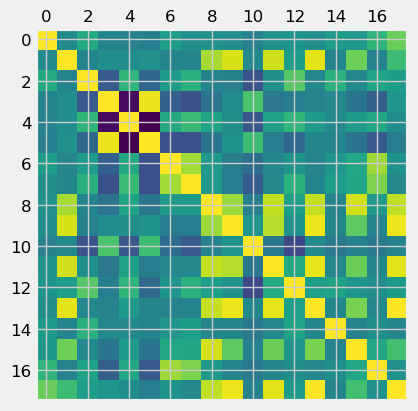

In [2603]:
import matplotlib.pyplot as plt

plt.matshow(wme_df.corr())
plt.show()

In [2604]:
predictors = ['GlobalMethane(ktco2)', 'LandArea(count)', 'CO2Emission(kt)', 'AgricultureMethane(ktco2)','EnergieMethane(ktco2)', 'AirTransport', 'note_year']
# predictors = ['GlobalMethane(ktco2)', 'CO2Emission(kt)', 'AgricultureMethane(ktco2)','EnergieMethane(ktco2)', 'AirTransport', 'note_year']
feature_selected = ['economy', 'year'] + predictors

In [2605]:
wme_df_final = wme_df[feature_selected]

In [2606]:
wme_df_final

,economy,year,GlobalMethane(ktco2),LandArea(count),CO2Emission(kt),AgricultureMethane(ktco2),EnergieMethane(ktco2),AirTransport,note_year
0,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
1,ABW,1961,NaN,180.0,NaN,NaN,NaN,NaN,-1.000000
2,ABW,1962,NaN,180.0,NaN,NaN,NaN,NaN,-1.000000
3,ABW,1963,NaN,180.0,NaN,NaN,NaN,NaN,-1.000000
4,ABW,1964,NaN,180.0,NaN,NaN,NaN,NaN,-1.000000
...,...,...,...,...,...,...,...,...,...
16177,ZWE,2017,12060.000420,386850.0,10340.000153,6250.0,2970.0,3444.0,0.014581
16178,ZWE,2018,12340.000153,386850.0,12380.000114,6420.0,3020.0,3444.0,0.014629
16179,ZWE,2019,12550.000191,386850.0,11760.000229,6540.0,3070.0,NaN,0.014646
16180,ZWE,2020,NaN,386850.0,NaN,NaN,NaN,3450.0,-1.000000


In [2607]:
wme_df_final.to_csv('World_methane_emission_first_notation.csv')

### feature_selection

In [2608]:
wme_df_final_2015 = wme_df_final[wme_df_final['year'] == 2007]

In [2609]:
wme_df_final_2015

,economy,year,GlobalMethane(ktco2),LandArea(count),CO2Emission(kt),AgricultureMethane(ktco2),EnergieMethane(ktco2),AirTransport,note_year
47,ABW,2007,NaN,1.800000e+02,NaN,NaN,NaN,NaN,-1.000000
109,AFE,2007,468919.998476,1.472027e+07,486179.996997,304150.0,111450.0,359120.0,0.632503
171,AFG,2007,11609.999657,6.522300e+05,1769.999981,8800.0,500.0,NaN,0.015660
233,AFW,2007,286409.999803,9.045780e+06,142610.002428,151300.0,101720.0,NaN,0.386324
295,AGO,2007,35330.001831,1.246700e+06,16969.999313,17490.0,16870.0,5277.0,0.047655
...,...,...,...,...,...,...,...,...,...
15919,XKX,2007,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
15981,YEM,2007,19940.000534,5.279700e+05,23270.000458,4230.0,13800.0,14403.0,0.026896
16043,ZAF,2007,74199.996948,1.213090e+06,397059.997559,17130.0,38800.0,152550.0,0.100085
16105,ZMB,2007,13710.000038,7.433900e+05,1980.000019,10120.0,1170.0,6396.0,0.018493


In [2610]:
wme_df_final_2015 = wme_df_final_2015.dropna(subset=feature_selected)
wme_df_final_2015 = wme_df_final_2015.reset_index()
wme_df_final_2015

,index,economy,year,GlobalMethane(ktco2),LandArea(count),CO2Emission(kt),AgricultureMethane(ktco2),EnergieMethane(ktco2),AirTransport,note_year
0,109,AFE,2007,468919.998476,1.472027e+07,4.861800e+05,304150.0,111450.0,359120.0,0.632503
1,295,AGO,2007,35330.001831,1.246700e+06,1.697000e+04,17490.0,16870.0,5277.0,0.047655
2,357,ALB,2007,3299.999952,2.740000e+04,4.140000e+03,2300.0,80.0,4930.0,0.004451
3,481,ARB,2007,625570.010230,1.361133e+07,1.303116e+06,116880.0,400570.0,516679.0,0.843800
4,605,ARG,2007,130809.997559,2.736690e+06,1.628100e+05,91770.0,21630.0,79465.0,0.176443
...,...,...,...,...,...,...,...,...,...,...
155,15733,VNM,2007,78919.998169,3.125580e+05,1.051400e+05,49530.0,15700.0,60218.0,0.106451
156,15981,YEM,2007,19940.000534,5.279700e+05,2.327000e+04,4230.0,13800.0,14403.0,0.026896
157,16043,ZAF,2007,74199.996948,1.213090e+06,3.970600e+05,17130.0,38800.0,152550.0,0.100085
158,16105,ZMB,2007,13710.000038,7.433900e+05,1.980000e+03,10120.0,1170.0,6396.0,0.018493


In [2611]:
data = wme_df_final_2015[predictors].copy()
data

,GlobalMethane(ktco2),LandArea(count),CO2Emission(kt),AgricultureMethane(ktco2),EnergieMethane(ktco2),AirTransport,note_year
0,468919.998476,1.472027e+07,4.861800e+05,304150.0,111450.0,359120.0,0.632503
1,35330.001831,1.246700e+06,1.697000e+04,17490.0,16870.0,5277.0,0.047655
2,3299.999952,2.740000e+04,4.140000e+03,2300.0,80.0,4930.0,0.004451
3,625570.010230,1.361133e+07,1.303116e+06,116880.0,400570.0,516679.0,0.843800
4,130809.997559,2.736690e+06,1.628100e+05,91770.0,21630.0,79465.0,0.176443
...,...,...,...,...,...,...,...
155,78919.998169,3.125580e+05,1.051400e+05,49530.0,15700.0,60218.0,0.106451
156,19940.000534,5.279700e+05,2.327000e+04,4230.0,13800.0,14403.0,0.026896
157,74199.996948,1.213090e+06,3.970600e+05,17130.0,38800.0,152550.0,0.100085
158,13710.000038,7.433900e+05,1.980000e+03,10120.0,1170.0,6396.0,0.018493


#### Normalisation de la data

In [2612]:
data = ((data - data.min()) / (data.max() - data.min())) * 9 + 1

In [2613]:
data.describe()

,GlobalMethane(ktco2),LandArea(count),CO2Emission(kt),AgricultureMethane(ktco2),EnergieMethane(ktco2),AirTransport,note_year
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000
mean,1.871402,1.862432,1.699666,1.900461,1.686301,1.429156,1.871402
std,1.689100,1.655250,1.752309,1.781474,1.466863,1.363329,1.689100
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.022073,1.015318,1.006219,1.017126,1.004857,1.005873,1.022073
50%,1.087123,1.077881,1.042076,1.096973,1.037878,1.023743,1.087123
75%,1.648762,1.472192,1.333876,1.489227,1.445570,1.191251,1.648762
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Text(0, 0.5, 'Inertia')

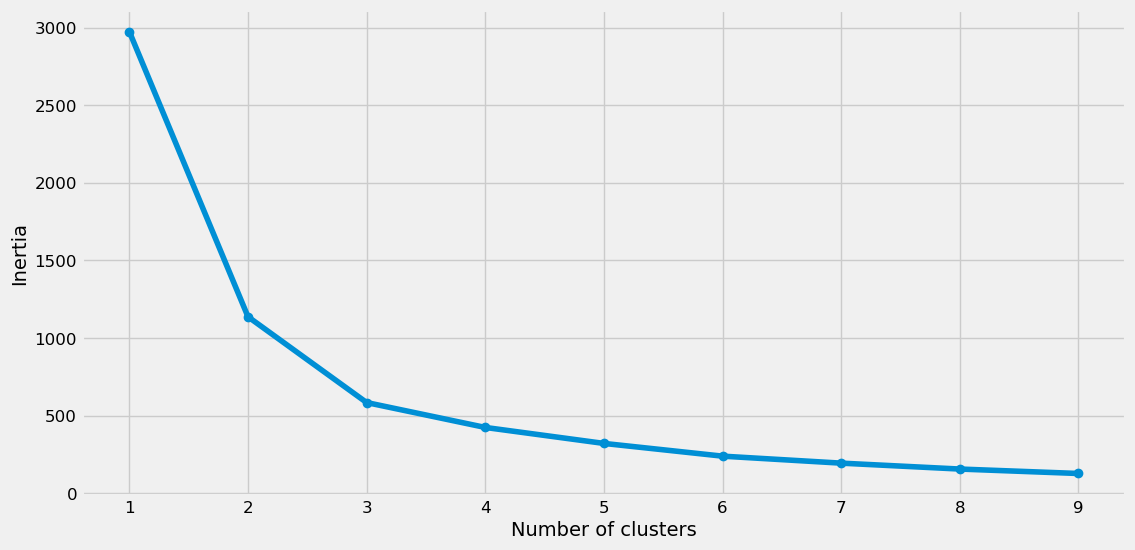

In [2614]:
SSE = []

for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(data)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

### We can see that the optimal number of clusters is 4. (The elbow of the graph)

In [2615]:
from sklearn.cluster import KMeans
kmeans = KMeans(3)
kmeans.fit(data)

KMeans(n_clusters=3)

In [2616]:
pd.DataFrame(kmeans.cluster_centers_, columns=predictors).T

,0,1,2
GlobalMethane(ktco2),1.112918,6.995686,3.291651
LandArea(count),1.109003,6.251122,3.569979
CO2Emission(kt),1.086857,7.283539,2.236321
AgricultureMethane(ktco2),1.118598,6.790252,3.530513
EnergieMethane(ktco2),1.080180,5.830692,2.800324
AirTransport,1.066990,4.701586,1.757990
note_year,1.112918,6.995686,3.291651


In [2617]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_clusters(data, labels, centroids):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()

In [2618]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

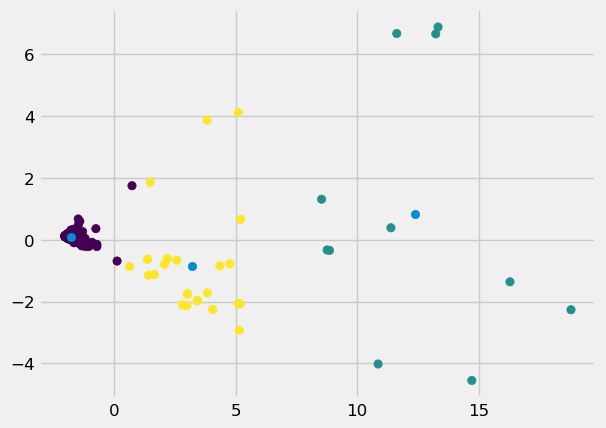

In [2619]:
plot_clusters(data, labels, centroids.T)

In [2620]:
labels = pd.DataFrame(labels, columns = ['labels'])
labels

,labels
0,2
1,0
2,0
3,2
4,0
...,...
155,0
156,0
157,0
158,0


In [2621]:
wme_df_final_2015 = wme_df_final_2015.merge(labels, left_index=True, right_index=True)

In [2622]:
wme_df_final_2015

,index,economy,year,GlobalMethane(ktco2),LandArea(count),CO2Emission(kt),AgricultureMethane(ktco2),EnergieMethane(ktco2),AirTransport,note_year,labels
0,109,AFE,2007,468919.998476,1.472027e+07,4.861800e+05,304150.0,111450.0,359120.0,0.632503,2
1,295,AGO,2007,35330.001831,1.246700e+06,1.697000e+04,17490.0,16870.0,5277.0,0.047655,0
2,357,ALB,2007,3299.999952,2.740000e+04,4.140000e+03,2300.0,80.0,4930.0,0.004451,0
3,481,ARB,2007,625570.010230,1.361133e+07,1.303116e+06,116880.0,400570.0,516679.0,0.843800,2
4,605,ARG,2007,130809.997559,2.736690e+06,1.628100e+05,91770.0,21630.0,79465.0,0.176443,0
...,...,...,...,...,...,...,...,...,...,...,...
155,15733,VNM,2007,78919.998169,3.125580e+05,1.051400e+05,49530.0,15700.0,60218.0,0.106451,0
156,15981,YEM,2007,19940.000534,5.279700e+05,2.327000e+04,4230.0,13800.0,14403.0,0.026896,0
157,16043,ZAF,2007,74199.996948,1.213090e+06,3.970600e+05,17130.0,38800.0,152550.0,0.100085,0
158,16105,ZMB,2007,13710.000038,7.433900e+05,1.980000e+03,10120.0,1170.0,6396.0,0.018493,0


In [2623]:
wme_df_final_2015

,index,economy,year,GlobalMethane(ktco2),LandArea(count),CO2Emission(kt),AgricultureMethane(ktco2),EnergieMethane(ktco2),AirTransport,note_year,labels
0,109,AFE,2007,468919.998476,1.472027e+07,4.861800e+05,304150.0,111450.0,359120.0,0.632503,2
1,295,AGO,2007,35330.001831,1.246700e+06,1.697000e+04,17490.0,16870.0,5277.0,0.047655,0
2,357,ALB,2007,3299.999952,2.740000e+04,4.140000e+03,2300.0,80.0,4930.0,0.004451,0
3,481,ARB,2007,625570.010230,1.361133e+07,1.303116e+06,116880.0,400570.0,516679.0,0.843800,2
4,605,ARG,2007,130809.997559,2.736690e+06,1.628100e+05,91770.0,21630.0,79465.0,0.176443,0
...,...,...,...,...,...,...,...,...,...,...,...
155,15733,VNM,2007,78919.998169,3.125580e+05,1.051400e+05,49530.0,15700.0,60218.0,0.106451,0
156,15981,YEM,2007,19940.000534,5.279700e+05,2.327000e+04,4230.0,13800.0,14403.0,0.026896,0
157,16043,ZAF,2007,74199.996948,1.213090e+06,3.970600e+05,17130.0,38800.0,152550.0,0.100085,0
158,16105,ZMB,2007,13710.000038,7.433900e+05,1.980000e+03,10120.0,1170.0,6396.0,0.018493,0


In [2624]:
wme_df_final_2015 = compute_score(wme_df_final_2015, 'labels', 'GlobalMethane(ktco2)')

In [2625]:
wme_df_final_2015

,index,economy,year,GlobalMethane(ktco2),LandArea(count),CO2Emission(kt),AgricultureMethane(ktco2),EnergieMethane(ktco2),AirTransport,note_year,labels,note_labels
0,109,AFE,2007,468919.998476,1.472027e+07,4.861800e+05,304150.0,111450.0,359120.0,0.632503,2,0.401767
1,295,AGO,2007,35330.001831,1.246700e+06,1.697000e+04,17490.0,16870.0,5277.0,0.047655,0,0.395576
2,357,ALB,2007,3299.999952,2.740000e+04,4.140000e+03,2300.0,80.0,4930.0,0.004451,0,0.035010
3,481,ARB,2007,625570.010230,1.361133e+07,1.303116e+06,116880.0,400570.0,516679.0,0.843800,2,1.277714
4,605,ARG,2007,130809.997559,2.736690e+06,1.628100e+05,91770.0,21630.0,79465.0,0.176443,0,1.470408
...,...,...,...,...,...,...,...,...,...,...,...,...
155,15733,VNM,2007,78919.998169,3.125580e+05,1.051400e+05,49530.0,15700.0,60218.0,0.106451,0,0.886275
156,15981,YEM,2007,19940.000534,5.279700e+05,2.327000e+04,4230.0,13800.0,14403.0,0.026896,0,0.222329
157,16043,ZAF,2007,74199.996948,1.213090e+06,3.970600e+05,17130.0,38800.0,152550.0,0.100085,0,0.833141
158,16105,ZMB,2007,13710.000038,7.433900e+05,1.980000e+03,10120.0,1170.0,6396.0,0.018493,0,0.152197


In [2626]:
avg_df = wme_df_final_2015.groupby(['labels'], as_index=False).agg(
                      {'GlobalMethane(ktco2)':['mean','std'], 'note_year':['first']})

In [2630]:
avg_df

,labels,GlobalMethane(ktco2)_mean,GlobalMethane(ktco2)_std,note_year_first
0,0,3.739390e+04,58669.190086,0.047655
1,1,1.975635e+06,553864.261683,2.192906
2,2,7.552381e+05,202691.297472,0.632503


In [2628]:
avg_df.columns.values

array([('labels', ''), ('GlobalMethane(ktco2)', 'mean'),
       ('GlobalMethane(ktco2)', 'std'), ('note_year', 'first')],
      dtype=object)

In [2629]:
avg_df.columns = ['labels'] + ['_'.join(col) for col in avg_df.columns.values[1:]]

In [2491]:
avg_df

,labels,GlobalMethane(ktco2)_mean,GlobalMethane(ktco2)_std,note_year_mean
0,0,3.739390e+04,58669.190086,0.050439
1,1,1.975635e+06,553864.261683,2.664835
2,2,7.552381e+05,202691.297472,1.018703


In [2492]:
avg_df = avg_df.rename(columns={'GlobalMethane(ktco2)_mean' : 'Methane_emission_estimated',
                               'GlobalMethane(ktco2)_std': 'Incertainty_of_estimation',
                               'note_year_mean': 'note_cluster'})

In [2493]:
avg_df

,labels,Methane_emission_estimated,Incertainty_of_estimation,note_cluster
0,0,3.739390e+04,58669.190086,0.050439
1,1,1.975635e+06,553864.261683,2.664835
2,2,7.552381e+05,202691.297472,1.018703


In [2494]:
wme_df_final_2015 = wme_df_final_2015.merge(avg_df, how='left', on='labels')

In [2495]:
wme_df_final_2015[wme_df_final_2015['economy']=='QAT']

,index,economy,year,GlobalMethane(ktco2),LandArea(count),CO2Emission(kt),AgricultureMethane(ktco2),EnergieMethane(ktco2),AirTransport,note_year,labels,Methane_emission_estimated,Incertainty_of_estimation,note_cluster
119,12199,QAT,2007,12869.999886,11610.0,49830.001831,90.0,12100.0,62689.0,0.01736,0,37393.902566,58669.190086,0.050439


In [2632]:
wme_df_final_2015[wme_df_final_2015['economy']=='USA']

,index,economy,year,GlobalMethane(ktco2),LandArea(count),CO2Emission(kt),AgricultureMethane(ktco2),EnergieMethane(ktco2),AirTransport,note_year,labels,note_labels
152,15361,USA,2007,612919.98291,9161920.0,5.736320e+06,200350.0,266430.0,9815504.0,0.826737,2,1.206978


In [2505]:
wme_df_final_2015.loc[wme_df_final_2015['note_cluster'] == wme_df_final_2015['note_cluster'].max()]

,index,economy,year,GlobalMethane(ktco2),LandArea(count),CO2Emission(kt),AgricultureMethane(ktco2),EnergieMethane(ktco2),AirTransport,note_year,labels,Methane_emission_estimated,Incertainty_of_estimation,note_cluster
34,3829,EAP,2007,1.625760e+06,1.602321e+07,8.068468e+06,682450.0,629370.0,2702754.0,2.192906,1,1.975635e+06,553864.261683,2.664835
35,3891,EAR,2007,2.771270e+06,3.331394e+07,5.227578e+06,1315110.0,959570.0,2893009.0,3.738026,1,1.975635e+06,553864.261683,2.664835
36,3953,EAS,2007,1.856380e+06,2.449546e+07,1.069346e+07,830230.0,673210.0,4441653.0,2.503977,1,1.975635e+06,553864.261683,2.664835
38,4077,ECS,2007,1.405820e+06,2.743855e+07,6.919939e+06,412700.0,665400.0,6941099.0,1.896240,1,1.975635e+06,553864.261683,2.664835
53,5937,HIC,2007,1.675850e+06,3.524776e+07,1.363962e+07,669710.0,569810.0,19388111.0,2.260470,1,1.975635e+06,553864.261683,2.664835
82,8541,LMC,2007,2.152410e+06,2.484455e+07,3.668009e+06,1193860.0,571710.0,1795387.0,2.903277,1,1.975635e+06,553864.261683,2.664835
83,8665,LTE,2007,2.568790e+06,4.456148e+07,1.108912e+07,1012600.0,1174950.0,4686224.0,3.464911,1,1.975635e+06,553864.261683,2.664835
108,11021,OED,2007,1.660730e+06,3.551039e+07,1.328727e+07,748280.0,479820.0,19348839.0,2.240075,1,1.975635e+06,553864.261683,2.664835
118,12075,PST,2007,1.438830e+06,3.135031e+07,1.254088e+07,628640.0,426930.0,18271239.0,1.940765,1,1.975635e+06,553864.261683,2.664835
135,14059,TEA,2007,1.610660e+06,1.590262e+07,8.002750e+06,678420.0,619400.0,2700805.0,2.172538,1,1.975635e+06,553864.261683,2.664835


## Agriculture Sector

In [2269]:
sns.barplot(x='labels',y='AgricultureMethane(ktco2)',data=avg_df)

ValueError: Could not interpret input 'AgricultureMethane(ktco2)'

In [2270]:
sns.barplot(x='labels',y='EnergieMethane(ktco2)',data=avg_df)

ValueError: Could not interpret input 'EnergieMethane(ktco2)'

## Energy sector

<AxesSubplot: xlabel='labels', ylabel='AirTransport'>

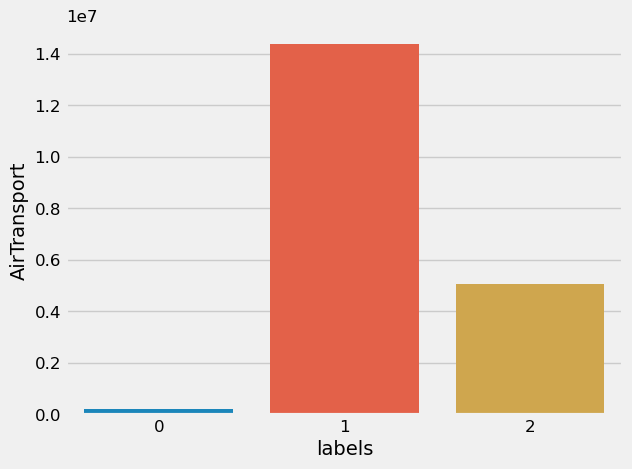

In [2044]:
sns.barplot(x='labels',y='AirTransport',data=avg_df)

<AxesSubplot: xlabel='labels', ylabel='CO2Emission(kt)'>

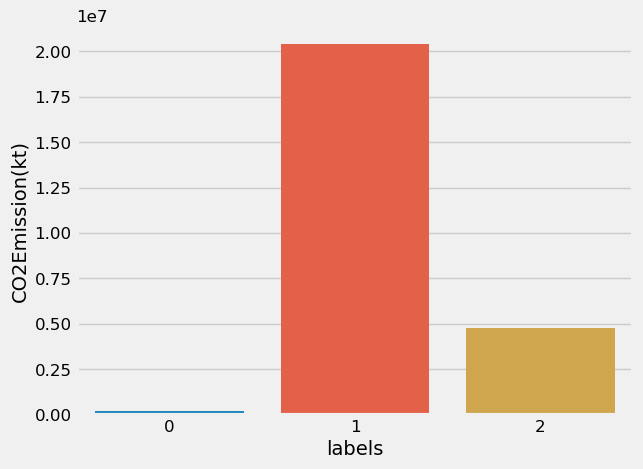

In [2045]:
sns.barplot(x='labels',y='CO2Emission(kt)',data=avg_df)

<AxesSubplot: xlabel='labels', ylabel='LandArea(count)'>

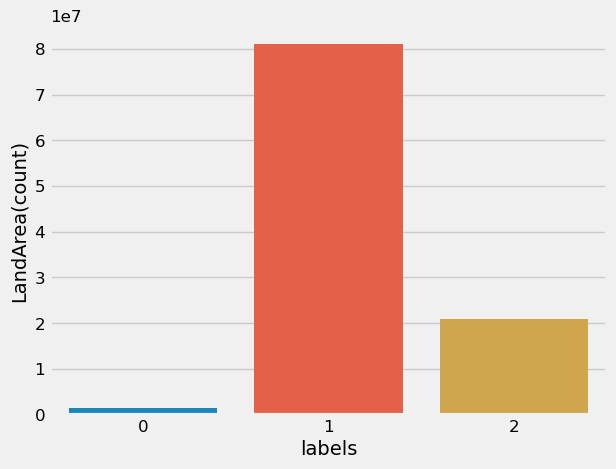

In [2046]:
sns.barplot(x='labels',y='LandArea(count)',data=avg_df)

## Both Energy and Agriculture sector

<AxesSubplot: xlabel='labels', ylabel='GlobalMethane(ktco2)'>

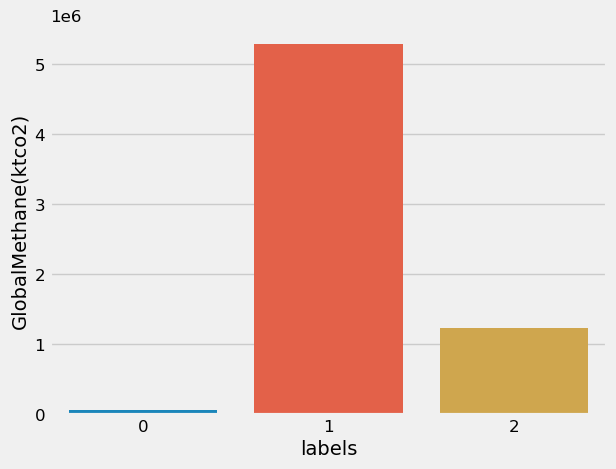

In [2047]:
sns.barplot(x='labels',y='GlobalMethane(ktco2)',data=avg_df)

### Building personas around each cluster

- Cluster 0 : Some country that have low average emission methane coming both from agriculture and energy
- Cluster 1 : some country that have Low average emission from Energy sector mid average emission from agriculture sector
- Cluster 2 : some country that have Low average emission from Agriculture sector mid average emission from Energy sector sector
- Cluster 3 : some country that have high average emission from both Agriculture and Energy sector

In [432]:
wme_df_origin

,index,Unnamed: 0,economy,time,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.AG.ZS,EN.ATM.METH.EG.KT.CE,EN.ATM.METH.EG.ZS,EN.ATM.METH.ZG,labels
0,0,0,ABW,YR1960,NaN,NaN,NaN,NaN,NaN,1.0
1,1,1,ABW,YR1961,NaN,NaN,NaN,NaN,NaN,1.0
2,2,2,ABW,YR1962,NaN,NaN,NaN,NaN,NaN,1.0
3,3,3,ABW,YR1963,NaN,NaN,NaN,NaN,NaN,1.0
4,4,4,ABW,YR1964,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...
16487,16487,16487,ZWE,YR2017,6250.0,NaN,2970.0,NaN,NaN,NaN
16488,16488,16488,ZWE,YR2018,6420.0,NaN,3020.0,NaN,NaN,NaN
16489,16489,16489,ZWE,YR2019,6540.0,NaN,3070.0,NaN,NaN,NaN
16490,16490,16490,ZWE,YR2020,NaN,NaN,NaN,NaN,NaN,NaN


In [436]:
wme_df_origin[(wme_df_origin['economy'] == 'FRA') & (wme_df_origin['EN.ATM.METH.EG.KT.CE'].isna())& (wme_df_origin['time']=='YR1970')]

,index,Unnamed: 0,economy,time,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.AG.ZS,EN.ATM.METH.EG.KT.CE,EN.ATM.METH.EG.ZS,EN.ATM.METH.ZG,labels
4784,4784,4784,FRA,YR1970,NaN,46.104492,NaN,39.862416,NaN,0.0


In [442]:
avg_df = wme_df_origin.groupby(['time', 'labels'], as_index=False).mean()
avg_df[avg_df['EN.ATM.METH.EG.KT.CE'].isna()]

,time,labels,index,Unnamed: 0,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.AG.ZS,EN.ATM.METH.EG.KT.CE,EN.ATM.METH.EG.ZS,EN.ATM.METH.ZG
0,YR1960,0.0,2565.846154,2565.846154,NaN,NaN,NaN,NaN,NaN
1,YR1960,1.0,2461.255814,2461.255814,NaN,NaN,NaN,NaN,NaN
2,YR1961,0.0,2544.347826,2544.347826,NaN,NaN,NaN,NaN,NaN
3,YR1961,1.0,2470.666667,2470.666667,NaN,NaN,NaN,NaN,NaN
4,YR1962,0.0,2534.461538,2534.461538,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
59,YR1989,1.0,2523.684211,2523.684211,NaN,45.429615,NaN,19.70218,NaN
120,YR2020,0.0,2533.473684,2533.473684,NaN,NaN,NaN,NaN,NaN
121,YR2020,1.0,2545.767442,2545.767442,NaN,NaN,NaN,NaN,NaN
122,YR2021,0.0,2573.347826,2573.347826,NaN,NaN,NaN,NaN,NaN
